In [1]:
import sys
import os

# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if necessary

# Add to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import sys
print(sys.executable)

/Users/cesarlindberg/anaconda3/envs/cardiac_pinn/bin/python


In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [572]:
# ---------------------------------------------
# 0) Imports & Setup
# ---------------------------------------------
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

from src.training.pinnex_data_loader import get_dataloaders
from src.networks.pinnex_models import PINNWithECG
from src.networks.pinn_wrapper import CachedPINNWrapper
from src.training.trainer_pinnex import train_pinnex_minibatch_with_ecg, train_lbfgs_with_ecg
from src.utils.evaluation import evaluate_pinnex, compute_metrics


In [580]:
# ---------------------------------------------
# 1) Load and Inspect Data
# ---------------------------------------------


n_epochs = 60
learning_rate = 1e-3
weight_decay = 1e-5
physics_weight = 0
batch_size = 512
batches_per_epoch = 128
phys_batch_size = 128*4
val_ratio = 0.15
val_every_n_epochs = 1

In [578]:
# Paths for spatiotemporal and ECG data
spatiotemp_path = "../data/synthetic/parsed/spatio_EIK_vol0.parquet"
ecg_path = "../data/synthetic/parsed/ecg_EIK_vol0.parquet"
spatiotemp_path = "../data/synthetic/parsed/activation_find_fib_hard.parquet"
ecg_path = "../data/synthetic/parsed/ecg_find_fib_hard.parquet"

train_loader, val_loader = get_dataloaders(
    spatiotemp_path=spatiotemp_path,
    ecg_path=ecg_path,
    batch_size=batch_size,
    val_ratio=val_ratio
)

Validation sim_ids: [577 280 442 109 304 558 427 523 296 431 321 584 491  70 316  28 210 434
 131 135  68 326 570 279 453 334 572  79 117 364  51  81 585 534 481 205
 540 203 380 373  14 150  45 477 291 254  18 506  25 129 215 256  75 184
 222 199 251 122 399  97 206 266 571 379 100  85 155 306 440 470 563 498
  87 592 247 102 599 510 595  56 156 389  30 512 323 344 297 444 233 415]


In [321]:
params = {"c": 12}

In [579]:
# ---------------------------------------------
# 4) Initialize Model & Hyperparameters
# ---------------------------------------------
base_model = PINNWithECG(
    pde_latent_dim=15,      # adjust as needed
    ecg_latent_dim=15,
    pde_hidden_architecture=[15, 15, 15, 15, 15, 15, 15],  # Example hidden layer sizes for PDE encoder
    ecg_hidden_architecture=[64, 32],  # Example hidden layer sizes for ECG encoder (FC part)
    decoder_hidden_architecture=[30, 30, 30, 30],  # Example hidden layer sizes for decoder
    n_leads=7,
    seq_len=101,
    fusion_mode="mult",
)

model = CachedPINNWrapper(base_model)

#model.load_state_dict(torch.load("models/pinnex_fib_190324_600epoch.pth"))

In [581]:

# ---------------------------------------------
# 5) Train the PINNEX
# ---------------------------------------------

train_loss, val_loss, data_loss, pde_loss = train_pinnex_minibatch_with_ecg(
    wrapper=model,
    train_loader=train_loader,
    val_loader=val_loader,
    params=params,
    n_epochs=n_epochs,
    lr=learning_rate,
    weight_decay=weight_decay,
    physics_weight=physics_weight,
    batches_per_epoch=batches_per_epoch,
    phys_batch_size=phys_batch_size,
    val_every_n_epochs=val_every_n_epochs,
    device='cpu'  # or 'cuda' if available
)


[Epoch 1/60] Train Loss: 1.0294e-02 | Data Loss: 1.0294e-02 | PDE Loss: 0.0000e+00 | Val Loss: 2.6427e-03
[Epoch 2/60] Train Loss: 2.9196e-03 | Data Loss: 2.9196e-03 | PDE Loss: 0.0000e+00 | Val Loss: 2.3591e-03
[Epoch 3/60] Train Loss: 2.5986e-03 | Data Loss: 2.5986e-03 | PDE Loss: 0.0000e+00 | Val Loss: 2.1554e-03
[Epoch 4/60] Train Loss: 2.3699e-03 | Data Loss: 2.3699e-03 | PDE Loss: 0.0000e+00 | Val Loss: 2.0349e-03
[Epoch 5/60] Train Loss: 2.1952e-03 | Data Loss: 2.1952e-03 | PDE Loss: 0.0000e+00 | Val Loss: 1.9885e-03
[Epoch 6/60] Train Loss: 2.0729e-03 | Data Loss: 2.0729e-03 | PDE Loss: 0.0000e+00 | Val Loss: 1.8346e-03
[Epoch 7/60] Train Loss: 2.0097e-03 | Data Loss: 2.0097e-03 | PDE Loss: 0.0000e+00 | Val Loss: 1.8394e-03
[Epoch 8/60] Train Loss: 1.9627e-03 | Data Loss: 1.9627e-03 | PDE Loss: 0.0000e+00 | Val Loss: 1.7647e-03
[Epoch 9/60] Train Loss: 1.9263e-03 | Data Loss: 1.9263e-03 | PDE Loss: 0.0000e+00 | Val Loss: 1.6677e-03
[Epoch 10/60] Train Loss: 1.9041e-03 | Data Lo

In [368]:
for res in results:
    print(f"ECG Arch: {res['ecg_arch']}, Val Loss: {res['t_loss'][-1]}")

ECG Arch: [256, 256, 128], Val Loss: 0.0015232145208857657
ECG Arch: [32, 32], Val Loss: 0.0011461008843359926
ECG Arch: [128, 128], Val Loss: 0.0016540684011848504
ECG Arch: [128, 64, 32], Val Loss: 0.0019510761401174395
ECG Arch: [256, 128, 64, 64, 32], Val Loss: 0.0024598588234901477
ECG Arch: [512, 256, 128, 64], Val Loss: 0.0016787866954288808
ECG Arch: [128, 64, 64, 32], Val Loss: 0.0023875866080835745
ECG Arch: [256, 128, 64], Val Loss: 0.0015071109969698872
ECG Arch: [64, 64], Val Loss: 0.000939264428161066
ECG Arch: [64, 32], Val Loss: 0.0015347384638114275
ECG Arch: [16, 8], Val Loss: 0.0018252171547936211
ECG Arch: [16, 16, 16, 16, 16], Val Loss: 0.0029517866106635693
ECG Arch: [64, 32, 32, 16], Val Loss: 0.002844775719110995


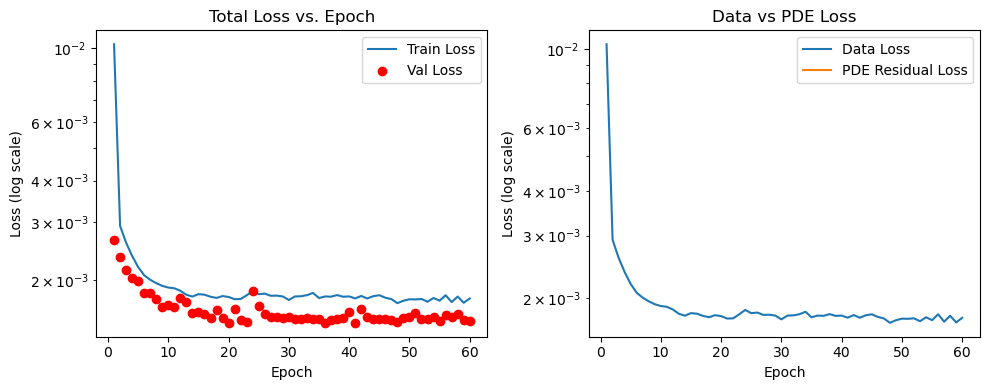

In [582]:
epochs = range(1, len(train_loss) + 1)
val_epochs = np.arange(val_every_n_epochs, len(train_loss) + 1, val_every_n_epochs)
plt.figure(figsize=(10, 4))
    
# Plot Total Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.scatter(val_epochs, val_loss, color='red', label='Val Loss', zorder=3)
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Total Loss vs. Epoch")
# Plot Data vs PDE Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, data_loss, label='Data Loss')
plt.plot(epochs, pde_loss, label='PDE Residual Loss')
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")  
plt.legend()
plt.title("Data vs PDE Loss")

plt.tight_layout()
plt.show()


In [22]:
saved = model

In [456]:

train_loss, val_loss, data_loss, pde_loss = train_lbfgs_with_ecg(model,
                         train_loader,
                         val_loader,
                         n_epochs=5,
                         lr=1e-3,
                         physics_weight=physics_weight,
                         device='cpu')

KeyboardInterrupt: 

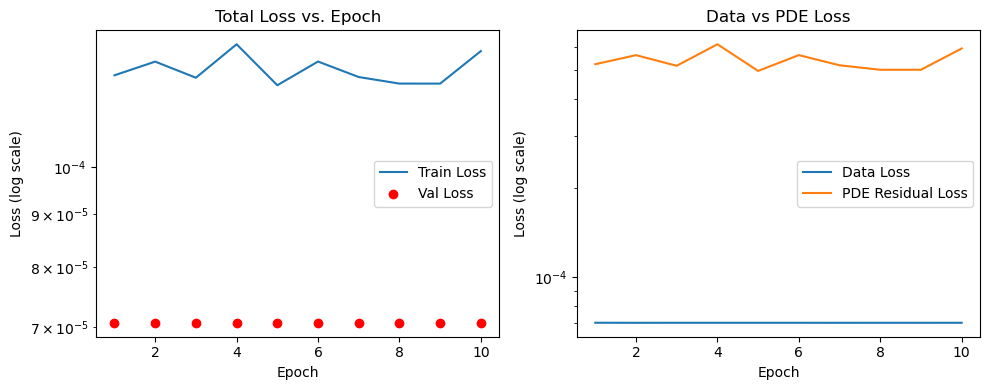

In [65]:
# Define x-axis values
epochs = np.arange(1, len(train_loss) + 1)
val_every_n_epochs = 1  # update this if different
val_epochs = np.arange(val_every_n_epochs, len(train_loss) + 1, val_every_n_epochs)

# Trim val_loss to match number of validation points
val_loss_trimmed = val_loss[:len(val_epochs)]

# Create plots
plt.figure(figsize=(10, 4))

# Plot Total Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.scatter(val_epochs, val_loss_trimmed, color='red', label='Val Loss', zorder=3)
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Total Loss vs. Epoch")

# Plot Data vs PDE Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, data_loss, label='Data Loss')
plt.plot(epochs, pde_loss, label='PDE Residual Loss')
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.title("Data vs PDE Loss")

plt.tight_layout()
plt.show()

In [583]:
# Run Evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Evaluate model on validation set
true_T, pred_T, pred_c = evaluate_pinnex(base_model, val_loader, device)

# Compute metrics for activation time T
re_T, mse_T, cc_T = compute_metrics(true_T, pred_T)

# Print results
print("------ Evaluation Results ------")
print(f"Relative Error (RE) for T: {re_T:.4f}")
print(f"Mean Squared Error (MSE) for T: {mse_T:.4f}")
print(f"Correlation Coefficient (CC) for T: {cc_T:.4f}")


------ Evaluation Results ------
Relative Error (RE) for T: 0.1191
Mean Squared Error (MSE) for T: 0.0018
Correlation Coefficient (CC) for T: 0.9388


In [201]:
# Save the trained model
torch.save(model.state_dict(), "models/eik_phys005_FIB.pth")
# TO LOAD
#model.load_state_dict(torch.load("pinn_mod1.pth"))
#model.eval()

In [327]:
from src.utils.igb_utils import write_pinnex_predictions_streamed

write_pinnex_predictions_streamed(base_model, 
                                  block_pts_file="../data/synthetic/raw/block_cube_08.pts", 
                                  ecg_parquet_file="../data/synthetic/parsed/ecg_find_fib_inter.parquet",
                                  sim_id=14,
                                  filename='pred_T_test.dat', 
                                  CV=True
                                 )
                          
#igbhead -x11767 -y1 -z1 -t5001 -dfloat --create -f vm_phys.igb predictions_PINN.txt to convert to igb

Starting PINN-ECG prediction process...
Reading block.pts file...
Loaded 17576 spatial points.
Loading ECG data for sim_id 14 from ../data/synthetic/parsed/ecg_find_fib_inter.parquet...
Loaded ECG data with shape torch.Size([1, 391]).
Streaming spatial data and running inference...
Prediction process completed. Results written to pred_T_test.dat
Converting predictions to igb format with command: igbhead -x17576 -y1 -z1 -dfloat --create -f pred_T_test.igb pred_T_test.dat
Temporary prediction file removed. Process complete.


In [559]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count parameters for each component
pde_encoder_params = count_parameters(base_model.pde_encoder)
ecg_encoder_params = count_parameters(base_model.ecg_encoder)

print(f"PDE Encoder Parameters: {pde_encoder_params}")
print(f"ECG Encoder Parameters: {ecg_encoder_params}")
print(f"Total Model Parameters: {pde_encoder_params + ecg_encoder_params}")

# Print the model's weights
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Size: {param.size()}) # | Values: \n{param.data}\n")


PDE Encoder Parameters: 2010
ECG Encoder Parameters: 16449
Total Model Parameters: 18459
Layer: model.pde_encoder.network.0.linear.weight | Size: torch.Size([15, 3])) # | Values: 
tensor([[ 0.3493,  0.3741, -0.2757],
        [ 0.0116,  0.2690,  0.1303],
        [ 0.0158,  0.0041,  0.0126],
        [-0.2431, -0.3741,  0.1621],
        [-0.1789,  0.0925, -0.0536],
        [ 0.0158,  0.0042,  0.0126],
        [ 0.0158,  0.0042,  0.0126],
        [-0.0057,  0.2325,  0.4604],
        [ 0.4928, -0.3114,  0.1501],
        [ 0.0158,  0.0042,  0.0126],
        [-0.3903,  0.3314, -0.2441],
        [ 0.0158,  0.0042,  0.0126],
        [-0.0861, -0.3451, -0.3927],
        [ 0.0158,  0.0042,  0.0126],
        [ 0.0246, -0.0640,  0.3540]])

Layer: model.pde_encoder.network.0.linear.bias | Size: torch.Size([15])) # | Values: 
tensor([-0.2769, -0.1991, -0.0055,  0.2091, -0.1313, -0.0054, -0.0054, -0.2508,
        -0.2571, -0.0053,  0.1175, -0.0054,  0.1255, -0.0054, -0.0273])

Layer: model.pde_encoder